In [97]:
from netCDF4 import Dataset
import numpy as np
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [98]:
def filter_grid_point(df, lat, lon):
    filtered_df = df[(df['Lat']==lat) & (df['Lon']==lon)]
    if not filtered_df.empty:
        rain = filtered_df.iloc[0]['Rain']
        return rain
    else:
        return 0.0

In [99]:
def get_netcdf_rfield(netcdf_file,grid_lon, grid_lat):
    nnc_fid = Dataset(netcdf_file, mode='r')
    time_unit_info = nnc_fid.variables['XTIME'].description
    time_unit_info_list = time_unit_info.split('since ')

    lats = nnc_fid.variables['XLAT'][0, :, 0]
    lons = nnc_fid.variables['XLONG'][0, 0, :]

    lon_min = lons[0].item()
    lat_min = lats[0].item()
    lon_max = lons[-1].item()
    lat_max = lats[-1].item()

    lat_inds = np.where((lats >= lat_min) & (lats <= lat_max))
    lon_inds = np.where((lons >= lon_min) & (lons <= lon_max))

    rainnc = nnc_fid.variables['RAINNC'][:, lat_inds[0], lon_inds[0]]
    times = nnc_fid.variables['XTIME'][:]
    nnc_fid.close()
    
    #diff = get_per_time_slot_values(rainnc)
    diff = rainnc
    width = len(lons)
    height = len(lats)
    
    plot_list = []
    
    for i in range(len(diff)):
        ts_time = datetime.strptime(time_unit_info_list[1], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=times[i].item())
        t = datetime_utc_to_lk(ts_time, shift_mins=0)
        timestamp = t.strftime('%Y-%m-%d %H-%M-00')
        ts_list = []
        for y in range(height):
            for x in range(width):
                lat = float('%.6f' % lats[y])
                lon = float('%.6f' % lons[x])
                rain = '%.3f' % float(diff[i, y, x])
                ts_list.append([lon, lat, rain])
        ts_df = pd.DataFrame(ts_list, columns=['Lon', 'Lat', 'Rain'])
        grid_point_rain = float(filter_grid_point(ts_df, grid_lat, grid_lon))
        plot_list.append([timestamp, grid_point_rain])
    return plot_list

In [100]:
def plot_grid_point_df(rain_source, netcdf_file,grid_lon, grid_lat):
    plot_list = get_netcdf_rfield(netcdf_file,grid_lon, grid_lat)
    if len(plot_list)>0:
        df = pd.DataFrame(plot_list, columns=['Time',rain_source])
        return df
    else:
        return None

In [101]:
def plot_grid_point_df_list(rain_source_list, netcdf_file_list, grid_lon, grid_lat):
    df_list = []
    i = 0
    for netcdf_file in netcdf_file_list:
        df = plot_grid_point_df(rain_source_list[i], netcdf_file,grid_lon, grid_lat)
        i+=1
        if df is not None:
            df_list.append(df)
    return df_list

In [102]:
def get_per_time_slot_values(prcp):
    per_interval_prcp = (prcp[1:] - prcp[:-1])
    return per_interval_prcp

def datetime_utc_to_lk(timestamp_utc, shift_mins=0):
    return timestamp_utc + timedelta(hours=5, minutes=30 + shift_mins)

In [103]:
def filter_rain(df, time):
    filtered_df = df[(df['Time']==time)]
    if not filtered_df.empty:
        rain = filtered_df.iloc[0]['Observed']
        return rain
    else:
        return 0.0
def get_obs_rain_df(observed_rain_file):
    observed_df = pd.read_csv(observed_rain_file)
    start_time = '2019-12-31 23-30-00'
    end_time = '2019-01-03 23-30-00'
    time_series = []
    rain = 0.0
    start_time = datetime.strptime(start_time, '%Y-%m-%d %H-%M-%S')
    end_time = datetime.strptime(end_time, '%Y-%m-%d %H-%M-%S')
    for i in range(289):
        timestamp = start_time.strftime('%Y-%m-%d %H-%M-%S')
        rain = rain+float(filter_rain(observed_df, timestamp))
        time_series.append([timestamp, rain])
        start_time = start_time + timedelta(minutes=15)
    obs_df = pd.DataFrame(time_series, columns=['Time','Observed'])
    #obs_df.plot(x='Time', y='Observed', kind='line', figsize=(20,10), grid=True)
    return obs_df

In [104]:
netcdf_files = ['/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_A_d03_RAINNC.nc', 
                '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_C_d03_RAINNC.nc',
               '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_E_d03_RAINNC.nc',
               '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_SE_d03_RAINNC.nc']
rain_sources = ['A','C','E','SE']

In [105]:
def plot_models_rfields_of_grid(model_list, netcdf_files,lon, lat):
    df_list = plot_grid_point_df_list(model_list, netcdf_files,lon, lat)
    for i in range(len(df_list)):
        print(df_list[i])
    plot_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time'), df_list)
    plot_df.plot(x='Time', y=model_list, kind='line', figsize=(20,10), grid=True)

                    Time    A
0    2019-12-31 23-30-00  0.0
1    2019-12-31 23-45-00  0.0
2    2020-01-01 00-00-00  0.0
3    2020-01-01 00-15-00  0.0
4    2020-01-01 00-30-00  0.0
..                   ...  ...
284  2020-01-03 22-30-00  0.0
285  2020-01-03 22-45-00  0.0
286  2020-01-03 23-00-00  0.0
287  2020-01-03 23-15-00  0.0
288  2020-01-03 23-30-00  0.0

[289 rows x 2 columns]
                    Time    C
0    2019-12-31 23-30-00  0.0
1    2019-12-31 23-45-00  0.0
2    2020-01-01 00-00-00  0.0
3    2020-01-01 00-15-00  0.0
4    2020-01-01 00-30-00  0.0
..                   ...  ...
284  2020-01-03 22-30-00  0.0
285  2020-01-03 22-45-00  0.0
286  2020-01-03 23-00-00  0.0
287  2020-01-03 23-15-00  0.0
288  2020-01-03 23-30-00  0.0

[289 rows x 2 columns]
                    Time    E
0    2019-12-31 23-30-00  0.0
1    2019-12-31 23-45-00  0.0
2    2020-01-01 00-00-00  0.0
3    2020-01-01 00-15-00  0.0
4    2020-01-01 00-30-00  0.0
..                   ...  ...
284  2020-01-03 22-30-

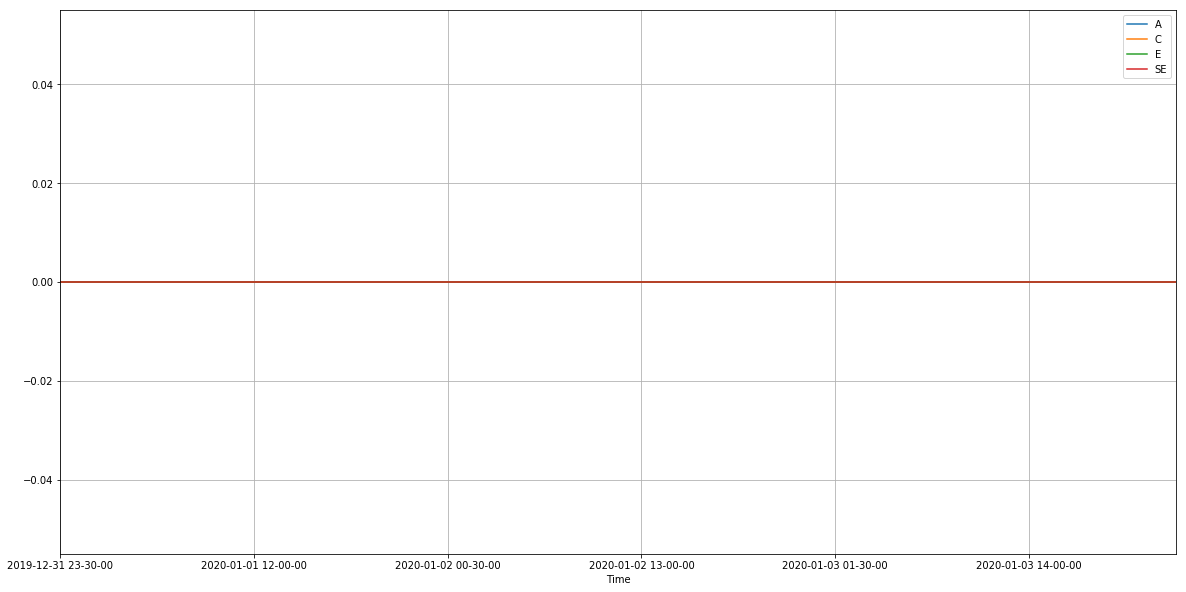

In [106]:
#plot_models_rfields_of_grid(rain_sources, netcdf_files, 80.556168, 7.102936)
plot_models_rfields_of_grid(rain_sources, netcdf_files, 79.919000, 6.908000)

In [56]:
rain_A_df = plot_grid_point_df('A', '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_A_d03_RAINNC.nc',79.919000, 6.908000)
rain_A_df

,Time,A
0,2019-12-31 23-30-00,0.0
1,2019-12-31 23-45-00,0.0
2,2020-01-01 00-00-00,0.0
3,2020-01-01 00-15-00,0.0
4,2020-01-01 00-30-00,0.0
...,...,...
284,2020-01-03 22-30-00,0.0
285,2020-01-03 22-45-00,0.0
286,2020-01-03 23-00-00,0.0
287,2020-01-03 23-15-00,0.0


In [75]:
observed_rain_file = '/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/obs_colombo07.csv'
obs_df = get_obs_rain_df(observed_rain_file)
obs_df

,Time,Observed
0,2019-12-31 23-30-00,0.0
1,2019-12-31 23-45-00,0.0
2,2020-01-01 00-00-00,0.0
3,2020-01-01 00-15-00,0.0
4,2020-01-01 00-30-00,0.0
...,...,...
284,2020-01-03 22-30-00,110.4
285,2020-01-03 22-45-00,110.4
286,2020-01-03 23-00-00,110.4
287,2020-01-03 23-15-00,110.4


In [62]:
rain_C_df = plot_grid_point_df('C', '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_C_d03_RAINNC.nc',79.919000, 6.908000)
rain_C_df

,Time,C
0,2019-12-31 23-30-00,0.0
1,2019-12-31 23-45-00,0.0
2,2020-01-01 00-00-00,0.0
3,2020-01-01 00-15-00,0.0
4,2020-01-01 00-30-00,0.0
...,...,...
284,2020-01-03 22-30-00,0.0
285,2020-01-03 22-45-00,0.0
286,2020-01-03 23-00-00,0.0
287,2020-01-03 23-15-00,0.0


In [61]:
rain_E_df = plot_grid_point_df('E', '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_E_d03_RAINNC.nc',79.919000, 6.908000)
rain_E_df

,Time,E
0,2019-12-31 23-30-00,0.0
1,2019-12-31 23-45-00,0.0
2,2020-01-01 00-00-00,0.0
3,2020-01-01 00-15-00,0.0
4,2020-01-01 00-30-00,0.0
...,...,...
284,2020-01-03 22-30-00,0.0
285,2020-01-03 22-45-00,0.0
286,2020-01-03 23-00-00,0.0
287,2020-01-03 23-15-00,0.0


In [63]:
rain_SE_df = plot_grid_point_df('SE', '/home/hasitha/PycharmProjects/DSS-Framework/output/netcdf/2020-01-02_output_wrf_SE_d03_RAINNC.nc',79.919000, 6.908000)
rain_SE_df

,Time,SE
0,2019-12-31 23-30-00,0.0
1,2019-12-31 23-45-00,0.0
2,2020-01-01 00-00-00,0.0
3,2020-01-01 00-15-00,0.0
4,2020-01-01 00-30-00,0.0
...,...,...
284,2020-01-03 22-30-00,0.0
285,2020-01-03 22-45-00,0.0
286,2020-01-03 23-00-00,0.0
287,2020-01-03 23-15-00,0.0


In [80]:
# plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [obs_df,rain_A_df,rain_C_df, rain_E_df,rain_SE_df])
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df, rain_E_df,rain_SE_df])

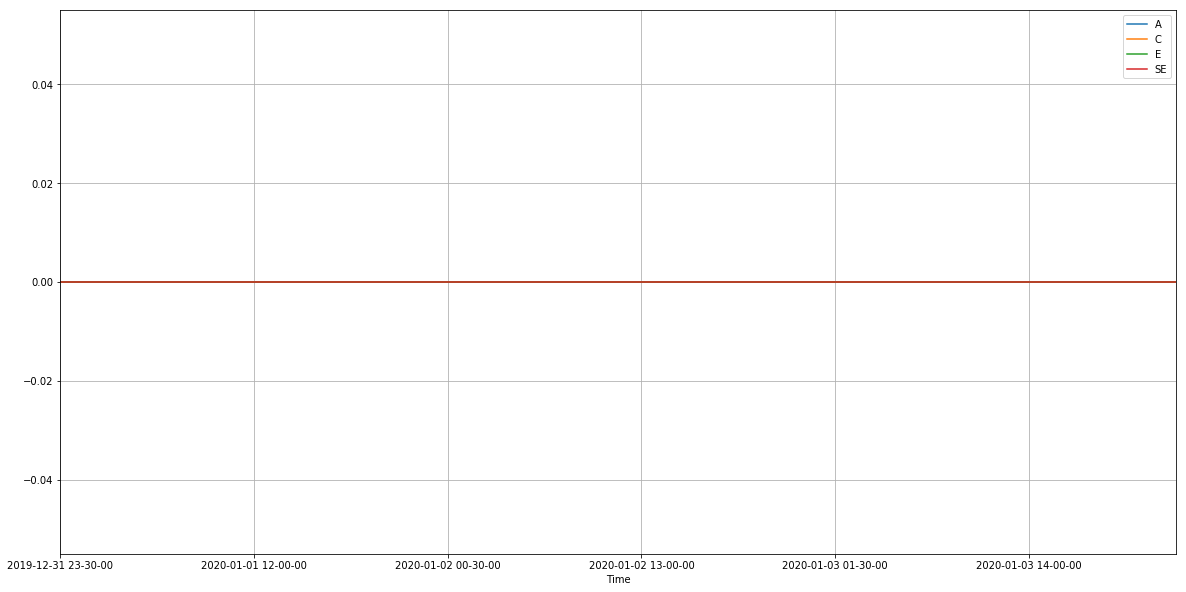

In [82]:
# plot_df.plot(x='Time', y=['Observed','A','C','E','SE'], kind='line', figsize=(20,10), grid=True)
plot_df.plot(x='Time', y=['A','C','E','SE'], kind='line', figsize=(20,10), grid=True)

In [142]:
def filter_rain_val(df, time):
    filtered_df = df[(df['time']==time)]
    if not filtered_df.empty:
        rain = filtered_df.iloc[0]['value']
        return rain
    else:
        return 0.0
    
def get_rain_df(rain_file, model):
    rain_df = pd.read_csv(rain_file)
    start_time = '2019-12-31 23:30:00'
    end_time = '2019-01-03 23:30:00'
    time_series = []
    rain = 0.0
    start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    for i in range(289):
        timestamp = start_time.strftime('%Y-%m-%d %H:%M:%S')
        rain = rain + float(filter_rain_val(rain_df, timestamp))
        time_series.append([timestamp, rain])
        start_time = start_time + timedelta(minutes=15)
    formatted_rain_df = pd.DataFrame(time_series, columns=['Time',model])
    return formatted_rain_df

In [147]:
rain_A_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_A_colombo07.csv','A')
rain_A_df

,Time,A
0,2019-12-31 23:30:00,0.000
1,2019-12-31 23:45:00,0.000
2,2020-01-01 00:00:00,0.000
3,2020-01-01 00:15:00,0.000
4,2020-01-01 00:30:00,0.000
...,...,...
284,2020-01-03 22:30:00,9.042
285,2020-01-03 22:45:00,9.042
286,2020-01-03 23:00:00,9.042
287,2020-01-03 23:15:00,9.042


In [144]:
rain_C_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_C_colombo07.csv','C')
rain_C_df

,Time,C
0,2019-12-31 23:30:00,0.000
1,2019-12-31 23:45:00,0.000
2,2020-01-01 00:00:00,0.000
3,2020-01-01 00:15:00,0.000
4,2020-01-01 00:30:00,0.000
...,...,...
284,2020-01-03 22:30:00,23.121
285,2020-01-03 22:45:00,23.218
286,2020-01-03 23:00:00,23.773
287,2020-01-03 23:15:00,23.824


In [148]:
rain_E_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_E_colombo07.csv','E')
rain_E_df

,Time,E
0,2019-12-31 23:30:00,0.000
1,2019-12-31 23:45:00,0.000
2,2020-01-01 00:00:00,0.000
3,2020-01-01 00:15:00,0.000
4,2020-01-01 00:30:00,0.000
...,...,...
284,2020-01-03 22:30:00,14.533
285,2020-01-03 22:45:00,14.533
286,2020-01-03 23:00:00,14.533
287,2020-01-03 23:15:00,14.533


In [149]:
rain_SE_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_SE_colombo07.csv','SE')
rain_SE_df

,Time,SE
0,2019-12-31 23:30:00,0.00
1,2019-12-31 23:45:00,0.00
2,2020-01-01 00:00:00,0.00
3,2020-01-01 00:15:00,0.00
4,2020-01-01 00:30:00,0.00
...,...,...
284,2020-01-03 22:30:00,2.87
285,2020-01-03 22:45:00,2.87
286,2020-01-03 23:00:00,2.87
287,2020-01-03 23:15:00,2.87


In [151]:
rain_obs_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/obs_colombo07.csv','Observed')
rain_obs_df

,Time,Observed
0,2019-12-31 23:30:00,0.0
1,2019-12-31 23:45:00,0.0
2,2020-01-01 00:00:00,0.0
3,2020-01-01 00:15:00,0.0
4,2020-01-01 00:30:00,0.0
...,...,...
284,2020-01-03 22:30:00,110.4
285,2020-01-03 22:45:00,110.4
286,2020-01-03 23:00:00,110.4
287,2020-01-03 23:15:00,110.4


In [153]:
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df,rain_E_df,rain_SE_df,rain_obs_df])
plot_df

,Time,A,C,E,SE,Observed
0,2019-12-31 23:30:00,0.000,0.000,0.000,0.00,0.0
1,2019-12-31 23:45:00,0.000,0.000,0.000,0.00,0.0
2,2020-01-01 00:00:00,0.000,0.000,0.000,0.00,0.0
3,2020-01-01 00:15:00,0.000,0.000,0.000,0.00,0.0
4,2020-01-01 00:30:00,0.000,0.000,0.000,0.00,0.0
...,...,...,...,...,...,...
284,2020-01-03 22:30:00,9.042,23.121,14.533,2.87,110.4
285,2020-01-03 22:45:00,9.042,23.218,14.533,2.87,110.4
286,2020-01-03 23:00:00,9.042,23.773,14.533,2.87,110.4
287,2020-01-03 23:15:00,9.042,23.824,14.533,2.87,110.4


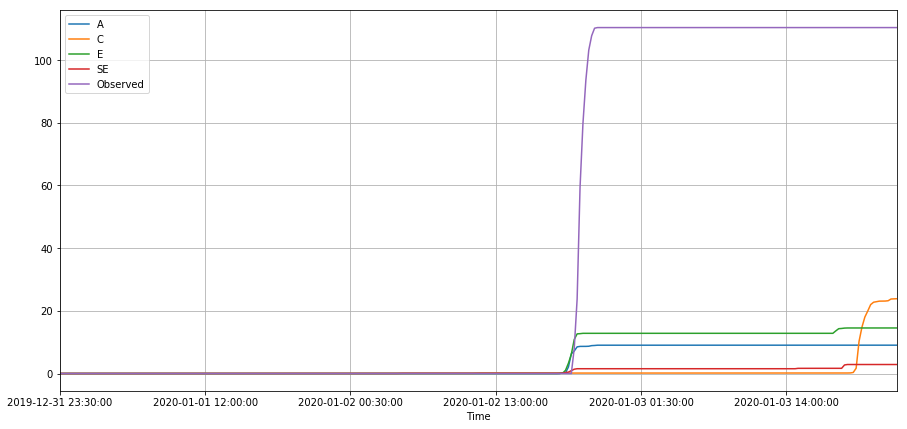

In [170]:
rain_A_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_A_colombo07.csv','A')
rain_C_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_C_colombo07.csv','C')
rain_E_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_E_colombo07.csv','E')
rain_SE_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/fcst_SE_colombo07.csv','SE')
rain_Observed_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/colombo07/obs_colombo07.csv','Observed')
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df,rain_E_df,rain_SE_df,rain_obs_df])
plot_df.plot(x='Time', y=['A','C','E','SE','Observed'], kind='line', figsize=(15,7), grid=True)

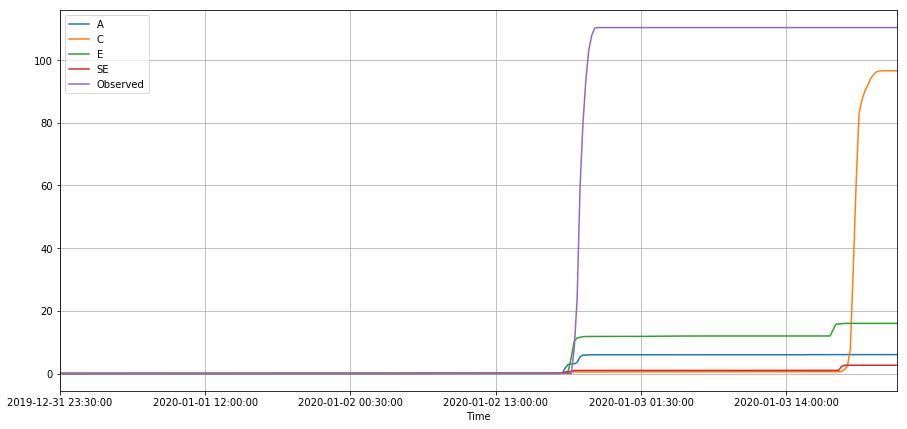

In [168]:
rain_A_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/battaramulla/fcst_A_battaramulla.csv','A')
rain_C_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/battaramulla/fcst_C_battaramulla.csv','C')
rain_E_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/battaramulla/fcst_E_battaramulla.csv','E')
rain_SE_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/battaramulla/fcst_SE_battaramulla.csv','SE')
rain_Observed_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/battaramulla/obs_battaramulla.csv','Observed')
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df,rain_E_df,rain_SE_df,rain_obs_df])
plot_df.plot(x='Time', y=['A','C','E','SE','Observed'], kind='line', figsize=(15,7), grid=True)

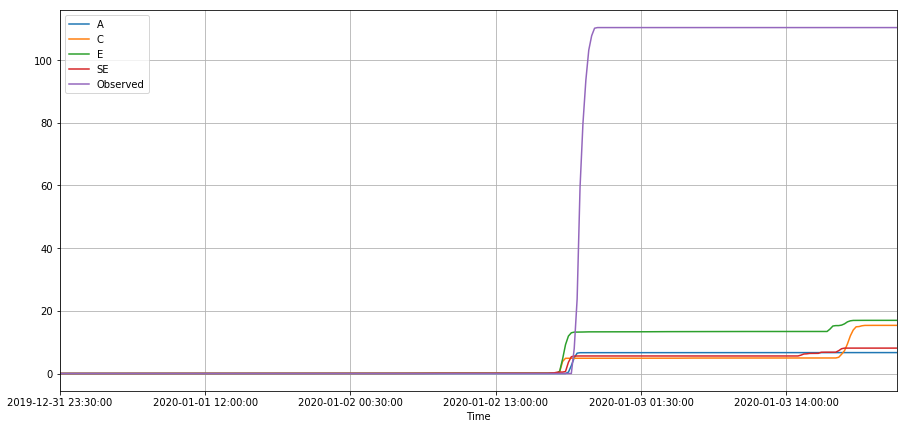

In [167]:
rain_A_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kaduwela/fcst_A_kaduwela.csv','A')
rain_C_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kaduwela/fcst_C_kaduwela.csv','C')
rain_E_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kaduwela/fcst_E_kaduwela.csv','E')
rain_SE_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kaduwela/fcst_SE_kaduwela.csv','SE')
rain_Observed_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kaduwela/obs_kaduwela.csv','Observed')
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df,rain_E_df,rain_SE_df,rain_obs_df])
plot_df.plot(x='Time', y=['A','C','E','SE','Observed'], kind='line', figsize=(15,7), grid=True)

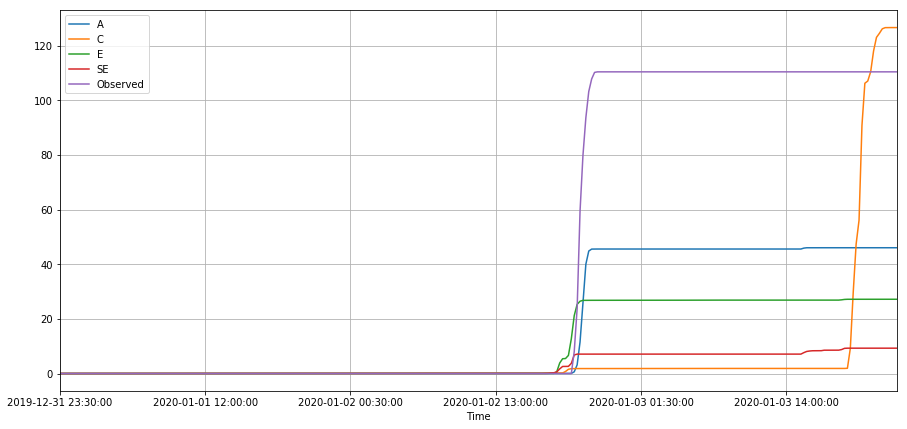

In [165]:
rain_A_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/gonawala/fcst_A_gonawala.csv','A')
rain_C_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/gonawala/fcst_C_gonawala.csv','C')
rain_E_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/gonawala/fcst_E_gonawala.csv','E')
rain_SE_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/gonawala/fcst_SE_gonawala.csv','SE')
rain_Observed_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/gonawala/obs_gonawala.csv','Observed')
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df,rain_E_df,rain_SE_df,rain_obs_df])
plot_df.plot(x='Time', y=['A','C','E','SE','Observed'], kind='line', figsize=(15,7), grid=True)

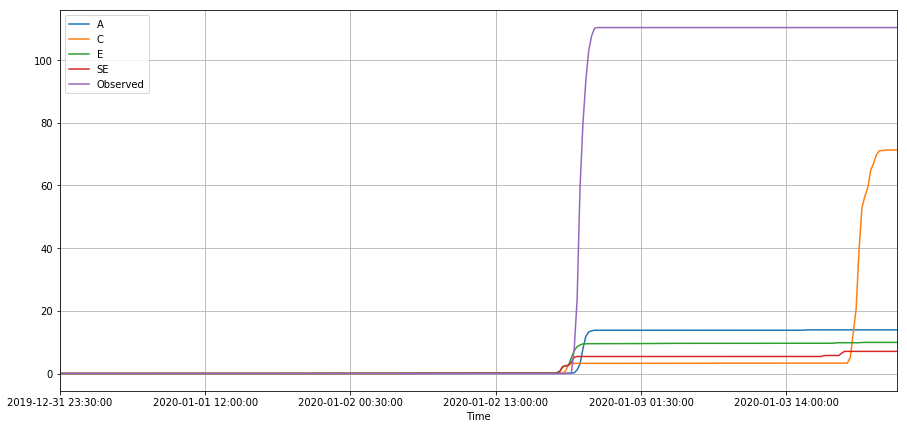

In [164]:
rain_A_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kotikawatta/fcst_A_kotikawatta.csv','A')
rain_C_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kotikawatta/fcst_C_kotikawatta.csv','C')
rain_E_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kotikawatta/fcst_E_kotikawatta.csv','E')
rain_SE_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kotikawatta/fcst_SE_kotikawatta.csv','SE')
rain_Observed_df = get_rain_df('/home/hasitha/PycharmProjects/DSS-Framework/output/rain/kotikawatta/obs_kotikawatta.csv','Observed')
plot_df = reduce(lambda x,y: pd.merge(x,y, on='Time', how='outer'), [rain_A_df,rain_C_df,rain_E_df,rain_SE_df,rain_obs_df])
plot_df.plot(x='Time', y=['A','C','E','SE','Observed'], kind='line', figsize=(15,7), grid=True)

##### 